# Lattice Geometries in TensorCircuit

## Quick Start Guide

**📋 Available Lattice Types:**

| Class | Description | Use Cases |
|-------|-------------|-----------|
| `SquareLattice` | 2D square grid with optional PBC | Spin models, quantum dots |
| `ChainLattice` | 1D linear chain | Time evolution, MPS algorithms |
| `HoneycombLattice` | 2D hexagonal structure | Graphene, topological materials |
| `CustomizeLattice` | Arbitrary finite geometry | Molecular clusters, defects, irregular structures |

**⚡ Key Methods:**
- `.get_site_info(index)` → Site details (index, identifier, coordinates)
- `.get_neighbors(site, k=1)` → k-th nearest neighbors of a site
- `.get_neighbor_pairs(k=1)` → All unique k-th nearest neighbor pairs
- `.show()` → Interactive visualization with matplotlib

---

This tutorial introduces the unified and extensible **Lattice API** in TensorCircuit, a powerful framework for defining and working with quantum systems on various geometric structures.

## Setup

**Environment Requirements:**
- TensorCircuit >= 1.3.0
- Optional: JAX backend for automatic differentiation support
- Python packages: `numpy`, `matplotlib`, `optax` (for optimization demos)

## What You'll Learn

By the end of this tutorial, you'll be able to:

🔹 **Build common lattices** (square, chain, honeycomb) and custom geometries  
🔹 **Query sites and neighbors** with configurable interaction ranges  
🔹 **Visualize lattices** with bonds and site indices  
🔹 **Generate physics Hamiltonians** (Heisenberg, Rydberg) directly from geometry  
🔹 **Create gate layers** for efficient parallel two-qubit operations  
🔹 **Explore differentiable geometry** for variational optimization  

## Architecture Overview

The API is centered around the **`AbstractLattice`** base class, with concrete implementations for:
- **Translationally invariant lattices**: `SquareLattice`, `HoneycombLattice`, `ChainLattice` 
- **Arbitrary custom geometries**: `CustomizeLattice` for finite clusters and irregular structures

This unified approach provides consistent interfaces while supporting both regular periodic structures and completely custom finite geometries.

In [42]:
# Essential imports for the lattice tutorial
import numpy as np
import matplotlib.pyplot as plt
import tensorcircuit as tc

# Import all lattice classes and utility functions
from tensorcircuit.templates.lattice import (
    AbstractLattice,
    SquareLattice,
    HoneycombLattice,
    ChainLattice,
    CustomizeLattice,
    get_compatible_layers,
)
from tensorcircuit.templates.hamiltonians import (
    heisenberg_hamiltonian,
    rydberg_hamiltonian,
)

# JAX backend is preferred for differentiable geometry optimization,
# but the API works with all TensorCircuit backends (numpy, jax, tensorflow, torch)
K = tc.set_backend("jax")
# Set precision to complex128 for better numerical accuracy
tc.set_dtype("complex128")
print("✅ Using JAX backend (supports automatic differentiation)")

K

✅ Using JAX backend (supports automatic differentiation)


jax_backend

## 1. Square Lattice: Basic Operations

We'll start by exploring a 3×3 square lattice with periodic boundary conditions (PBC). This demonstrates the core functionality: site information access, neighbor queries, and connectivity analysis.

**Key concepts:**
- **Site indexing**: Sites are numbered in row-major order (0-8 for a 3×3 grid)
- **Identifiers**: Each site has a tuple identifier (row, col, layer) for multi-dimensional lattices  
- **Periodic boundaries**: With `pbc=True`, edge sites connect to opposite edges
- **Neighbor shells**: `k=1` means nearest neighbors, `k=2` next-nearest neighbors, etc.

In [43]:
# Create a 3x3 square lattice with periodic boundary conditions and lattice constant 1.0
sq = SquareLattice(size=(3, 3), pbc=True, lattice_constant=1.0)

# Access basic lattice properties
print(f"num_sites: {sq.num_sites}")
print(f"dimensionality: {sq.dimensionality}")

# Get information about site 4 (center site in row-major ordering for 3x3)
idx, ident, coords = sq.get_site_info(4)
print("site 4 info ->", idx, ident, coords)

# Find nearest neighbors of site 4
nn = sq.get_neighbors(4, k=1)
print("nearest neighbors of site 4 ->", nn)

# Get all unique nearest-neighbor pairs
pairs = sq.get_neighbor_pairs(k=1, unique=True)
print("unique NN pairs (first 8) ->", pairs[:8], "...")

num_sites: 9
dimensionality: 2
site 4 info -> 4 (1, 1, 0) [1. 1.]
nearest neighbors of site 4 -> [1, 3, 5, 7]
unique NN pairs (first 8) -> [(0, 1), (0, 2), (0, 3), (0, 6), (1, 2), (1, 4), (1, 7), (2, 5)] ...


### Visualize the square lattice and bonds
Use `.show()` to plot sites and optional bonds.

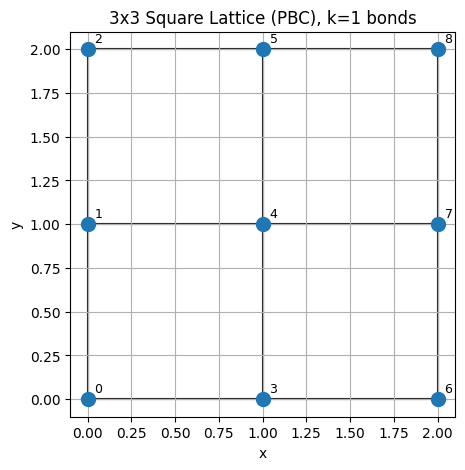

In [44]:
# Draw square lattice on a provided Axes to avoid extra blank figures
fig, ax = plt.subplots(figsize=(5, 5))
sq.show(ax=ax, show_indices=True, show_bonds_k=1)
ax.set_title("3x3 Square Lattice (PBC), k=1 bonds")
ax.set_aspect("equal")
plt.show()

## 2. Custom geometry: triangular fragment
For irregular or finite clusters, use `CustomizeLattice` with explicit coordinates and identifiers.

neighbors of site 2 -> [0, 1, 4, 5]


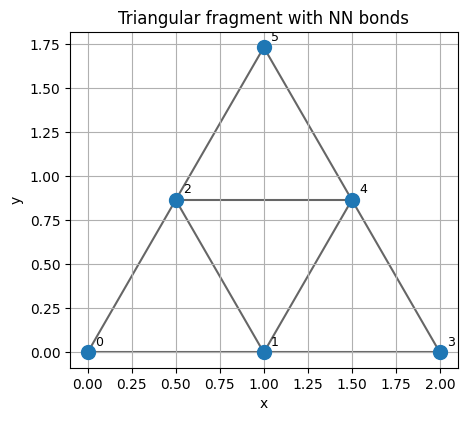

In [45]:
# Define a small triangular fragment
tri_coords = [
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, float(np.sqrt(3) / 2)],  # triangle 1
    [2.0, 0.0],
    [1.5, float(np.sqrt(3) / 2)],  # triangle 2
    [1.0, float(np.sqrt(3))],  # top site
]
tri_ids = list(range(len(tri_coords)))
tri = CustomizeLattice(dimensionality=2, identifiers=tri_ids, coordinates=tri_coords)
# Compute nearest neighbors on demand (k=1)
print("neighbors of site 2 ->", tri.get_neighbors(2, k=1))

# Draw triangular fragment on a provided Axes
fig, ax = plt.subplots(figsize=(5, 5))
tri.show(ax=ax, show_indices=True, show_bonds_k=1)
ax.set_title("Triangular fragment with NN bonds")
ax.set_aspect("equal")
plt.show()

## 3. From geometry to Hamiltonians
We can build sparse physics Hamiltonians directly from lattice connectivity and coordinates.

### 3.1 Heisenberg model on a 2x2 square lattice
Nearest-neighbor Heisenberg: H = J Σ⟨i,j⟩ (X_i X_j + Y_i Y_j + Z_i Z_j).

In [46]:
sq22 = SquareLattice(size=(2, 2), pbc=True)
Hh = heisenberg_hamiltonian(sq22, j_coupling=1.0, interaction_scope="neighbors")
print("Heisenberg(H) shape:", Hh.shape)
Hd = tc.backend.to_dense(Hh)
print("Hermitian check ->", np.allclose(Hd, Hd.conj().T))

Heisenberg(H) shape: (16, 16)
Hermitian check -> True


### 3.2 Rydberg atom array Hamiltonian
Includes on-site drive/detuning and distance-dependent interactions V_ij = C6/|r_i-r_j|^6.

In [47]:
chain2 = ChainLattice(size=(2,), pbc=False, lattice_constant=1.5)
Hr = rydberg_hamiltonian(chain2, omega=1.0, delta=-0.5, c6=10.0)
print("Rydberg(H) shape:", Hr.shape)
tc.backend.to_dense(Hr)  # display

Rydberg(H) shape: (4, 4)


Array([[-0.71947874+0.j,  0.5       +0.j,  0.5       +0.j,
         0.        +0.j],
       [ 0.5       +0.j, -0.21947874+0.j,  0.        +0.j,
         0.5       +0.j],
       [ 0.5       +0.j,  0.        +0.j, -0.21947874+0.j,
         0.5       +0.j],
       [ 0.        +0.j,  0.5       +0.j,  0.5       +0.j,
         1.15843621+0.j]], dtype=complex128)

## 4. Gate layering for NN two-qubit gates
To schedule parallel two-qubit gates on neighbors, group edges into disjoint layers.

In [48]:
pairs = sq.get_neighbor_pairs(k=1, unique=True)
layers = get_compatible_layers(pairs)
print("Number of layers:", len(layers))
for li, layer in enumerate(layers):
    head = layer[:6]
    suffix = " ..." if len(layer) > 6 else ""
    print("Layer", li, ":", head, suffix)

Number of layers: 5
Layer 0 : [(0, 1), (2, 5), (3, 4), (6, 7)] 
Layer 1 : [(0, 2), (1, 4), (3, 5), (6, 8)] 
Layer 2 : [(0, 3), (1, 2), (4, 5), (7, 8)] 
Layer 3 : [(0, 6), (1, 7), (2, 8)] 
Layer 4 : [(3, 6), (4, 7), (5, 8)] 


## 5. Differentiable geometry: optimize lattice constant (Lennard-Jones)

Below we demonstrate optimizing a geometric parameter (the lattice constant) using automatic differentiation.
We use a Lennard-Jones potential over all pairs as a simple, geometry-driven objective.

In [49]:
import optax


# Define a differentiable objective with log(a) parameterization to keep a>0
def lj_total_energy(log_a, epsilon=0.5, sigma=1.0, size=(4, 4)):
    a = K.exp(log_a)
    lat = SquareLattice(size=size, pbc=True, lattice_constant=a)
    d = lat.distance_matrix
    # More robust distance handling to avoid numerical issues
    d_safe = K.where(
        d > 1e-6, d, K.convert_to_tensor(1e6)
    )  # Large value for self-interactions
    term12 = K.power(sigma / d_safe, 12)
    term6 = K.power(sigma / d_safe, 6)
    e_mat = 4.0 * epsilon * (term12 - term6)
    n = lat.num_sites
    # Zero out diagonal (self-interactions) more explicitly
    mask = 1.0 - K.eye(n, dtype=e_mat.dtype)
    e_mat = e_mat * mask
    total_energy = K.sum(e_mat) / 2.0  # each pair counted twice
    return total_energy


val_and_grad = K.jit(K.value_and_grad(lj_total_energy))
opt = optax.adam(learning_rate=0.02)
log_a = K.convert_to_tensor(K.log(K.convert_to_tensor(1.2)))
state = opt.init(log_a)

hist_a = []
hist_e = []
for it in range(80):
    e, g = val_and_grad(log_a)
    hist_a.append(K.exp(log_a))
    hist_e.append(e)
    upd, state = opt.update(g, state)
    log_a = optax.apply_updates(log_a, upd)
    if (it + 1) % 20 == 0:
        print(f"iter {it+1}: E={float(e):.6f}, a={float(K.exp(log_a)):.6f}")

final_a = K.exp(log_a)
final_e = lj_total_energy(log_a)
print("Final:", f"E={float(final_e):.6f}", f"a={float(final_a):.6f}")

iter 20: E=-20.305588, a=1.116975
iter 40: E=-20.495401, a=1.104924
iter 60: E=-20.516659, a=1.099829
iter 80: E=-20.516122, a=1.100113
Final: E=-20.516308 a=1.100113


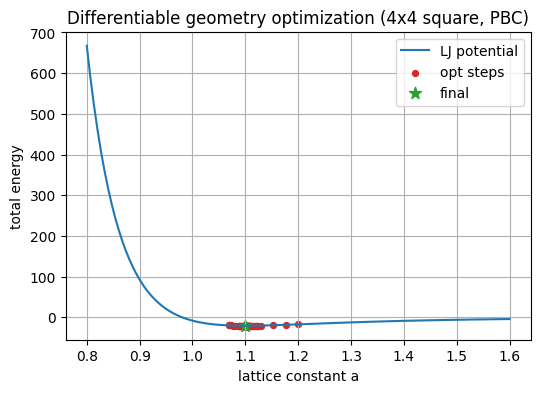

In [50]:
# Plot energy curve and optimization steps
# sample a-curve (NumPy for speed is fine)
a_grid = np.linspace(0.8, 1.6, 120)


def lj_energy_np(a, epsilon=0.5, sigma=1.0, size=(4, 4)):
    lat = SquareLattice(size=size, pbc=True, lattice_constant=float(a))
    d = lat.distance_matrix
    d = np.asarray(d)
    n = d.shape[0]
    mask = ~np.eye(n, dtype=bool)
    ds = d[mask]
    ds = np.where(ds > 1e-9, ds, 1e-9)
    e = 4 * epsilon * (np.sum((sigma / ds) ** 12 - (sigma / ds) ** 6)) / 2.0
    return float(e)


e_grid = [lj_energy_np(a) for a in a_grid]

# convert hist tensors to floats
hist_a_f = [float(x) for x in hist_a]
hist_e_f = [float(x) for x in hist_e]
fa = float(final_a)
fe = float(final_e)

plt.figure(figsize=(6, 4))
plt.plot(a_grid, e_grid, label="LJ potential")
plt.scatter(hist_a_f, hist_e_f, s=18, color="tab:red", label="opt steps")
plt.scatter([fa], [fe], s=80, color="tab:green", marker="*", label="final")
plt.xlabel("lattice constant a")
plt.ylabel("total energy")
plt.title("Differentiable geometry optimization (4x4 square, PBC)")
plt.legend()
plt.grid(True)
plt.show()

### Summary of differentiable demo
- The lattice constant `a` was treated as a differentiable parameter via `log(a)` reparameterization.
- We computed the Lennard-Jones energy using lattice distances and optimized it with Adam.
- For a full script and more iterations, see `examples/lennard_jones_optimization.py`.

# Further Reading and Resources

## API Reference
- **Core lattice classes**: `tensorcircuit/templates/lattice.py` - All lattice geometry classes
- **Hamiltonian utilities**: `tensorcircuit/templates/hamiltonians.py` - Physics Hamiltonian builders

## Complete Examples
Explore these examples in the `examples/` directory:
- **`lennard_jones_optimization.py`** - Full differentiable geometry optimization with JAX/Optax
- **`lattice_neighbor_benchmark.py`** - Performance comparison for different neighbor-finding algorithms

## Test Suite and Validation
The test suites showcase rich usage patterns and provide validation:
- **`tests/test_lattice.py`** - Comprehensive lattice functionality tests
- **`tests/test_hamiltonians.py`** - Physics Hamiltonian validation against analytical results

## Key Features Demonstrated
✅ **Unified API** for both regular and custom geometries  
✅ **Efficient neighbor finding** with configurable interaction shells  
✅ **Interactive visualization** with bonds and site labeling  
✅ **Physics-ready Hamiltonians** from geometric connectivity  
✅ **Parallel gate scheduling** for quantum circuit optimization  
✅ **Differentiable parameters** for variational material design  

## Performance Tips & Best Practices

### For Large Systems (N > 1000 sites):
- Use `CustomizeLattice` with KDTree neighbor building for better scalability
- Consider sparse representations for distance-dependent interactions
- Pre-compute neighbors with `_build_neighbors(max_k=...)` once

### Backend Selection:
- **JAX**: Best for differentiable geometry and automatic differentiation
- **NumPy**: Simple and reliable for static lattice analysis
- **TensorFlow/PyTorch**: For integration with existing ML pipelines

### Memory Efficiency:
- Distance matrices scale as O(N²) - use neighbor lists for very large systems
- For visualization: use `show_bonds_k=0` for large lattices to show only sites

### Precision Considerations:
- Use `tc.set_dtype("complex128")` for high-precision physics calculations
- Set `JAX_ENABLE_X64=True` to avoid precision warnings with complex numbers

---

**🎯 Next Steps**: Try building your own custom lattice geometry or implementing a new physics Hamiltonian using this framework!

In [51]:
# Environment info for reproducibility
print(tc.about())
print(
    "\n🎉 Tutorial completed successfully! You're now ready to use the lattice API in your quantum simulations."
)

OS info: Windows-10-10.0.26100-SP0
Python version: 3.10.5
Numpy version: 1.26.4
Scipy version: 1.15.3
Pandas version: 2.3.0
TensorNetwork version: 0.5.1
Cotengra version: 0.7.5
TensorFlow version: 2.15.1
TensorFlow GPU: []
TensorFlow CUDA infos: {'is_cuda_build': False, 'is_rocm_build': False, 'is_tensorrt_build': False, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll'}
Jax version: 0.4.34
Jax installation doesn't support GPU
JaxLib version: 0.4.34
PyTorch version: 2.7.1+cpu
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 2.1.1
Cirq version: 1.5.0
TensorCircuit version 1.3.0
None

🎉 Tutorial completed successfully! You're now ready to use the lattice API in your quantum simulations.
